In [3]:
import numpy
import scipy.special
import matplotlib.pyplot as plt
import math
import matplotlib.lines as mlines
from libeng.multiphase import drag_laws
plt.rcParams['figure.figsize'] = 14, 10

In [10]:
def NusseltGunn(Re, Pr, alpha_f):
#* Gunn (1978) correlation 


# Gunn1978 - Function to calculate the Nusselt (or Sherwood) number for the heat 
# (or mass) transfer using the Gunn (1978) correlation for dense flow of spherical particles.
# parameters:
# Re = Reynolds number based on particle diameter and relative velocity
# Pr = Prandtl number based on fluid properties (or Schmidt number for mass transfer)
# alpha_f = fluid volume (void) fraction
#
# returns:
# Nu = Gunn (1978) Nusselt (or Sherwood) number

# references:
# GUNN, D.; Transfer of Heat or Mass to Particles in Fixed and Fluidized Beds, 
# International Journal of Heat and Mass Transfer, volume 21, issue 4, pages 467-476, 1978.
# 

    Nu = (7.0 - 10.0 * alpha_f + 5.0 * alpha_f * alpha_f) * (1.0 + 0.7 * numpy.power(Re, 0.2) * numpy.power(Pr, 0.3333333333)) + \
    (1.33 - 2.4 * alpha_f + 1.2 * alpha_f * alpha_f) * numpy.power(Re, 0.7) * numpy.power(Pr, 0.3333333333)

    return Nu;

def packedBedTrnsMn(a,n):

# calculation of  parameters required for Schumann solution

    nMax = 30

    result = 0
    for i in range(n,nMax+1):
        piProduct = 1
        for j in range(0,n):
            piProduct = piProduct * (i-j)
                 
        result =  result + a**(i-n) * piProduct / (numpy.math.factorial(i))**2
    
    return(result)


def packedBedTrnsMnSum(y, z, nStart):
# calculation of summation bessel function required for Schumann solution
# INPUT
#   t  ...vector containing the dimensionless time
#   z  ...vector containing the dimentionless length
# OUTPUT
#   result    ...vector containing intermediate results of the Schumann solution

    nMax = 30

    a = y * z   
    result = 0
    for n in range (nStart,nMax+1):        
        result = result + z**(n) * packedBedTrnsMn(a,n)
    
    return(result)



def packedBedTrnsTemperatures(t, z):
#classical solution of Schumann
# INPUT
#   t         ...vector containing the dimensionless time
#  z         ...vector containing the dimentionless length
# OUTPUT
#   TgStar    ...vector of dimensionless gas temperature along the bed 
#   TpStar    ...vector of dimensionless particle temperature along the bed 

    TgStar =  1 -  numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 1) 

    TpStar = 1 - numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 0)
      
    return([TgStar, TpStar])


        

In [141]:
# fluid properties
rho_g = 1000.00 # [kg/m³] fluid density [kg/m^3]
mu_g = 0.001 # [Pa·s]  dynamic viscosity of fluid 
nu_g = mu_g/rho_g  # [kg/(m.s)] kinematic viscosity of fluid 
c_pg = 3000.0 # [J/kg·K] fluid heat capacity [J/(kg.K)]
T_gi = 500.0 # [K] inlet fluid temperature [K]
T_g0 = 300.0 # [K] initial fluid temperature [K]
k_g = 0.025  # [J/(m.K)] fluid conductivity 
Pr_g = c_pg*mu_g/k_g # [ ] Prandtl number 
print(Pr_g)

#particle properties
d_p = 0.001# [m] particle diameter [m]
rho_p = 5000.0 # [kg/m³] density of particle[kg/m^3]
c_pp = 500.0 # [J/kg·K] particle heat capacity [J/(kg.K)]
T_p0 = T_g0 # [K] initial particle temperature
k_p = 10.0  # [J/(m.K)] particle conductivity 
q_dot = 0.0 # [W/m³]
q_dot_spec = 0.0 #[kJ/(kg.s)] specific heat source 

#Mesh size
l_mesh = 10.0/1000.0 #m
#num_y = num_y + (l_mesh/2.0)
#operating conditions
U_s = 1.0 # [m/s] superficial velocity

epsilon_g = 1-0.574 # gas volume fraction [dimensionless][ ] 
U = U_s/ epsilon_g   # [m/s] this is the TRUE gas velocity, not superficial [m/s]
#h = 1.0 # [W/m²·K]
time_to_cross_domain = 0.5/(U)

courant = U*0.001/l_mesh
print("time to cross domain = ", time_to_cross_domain)
print("courant = ", courant)

120.0
time to cross domain =  0.21300000000000002
courant =  0.23474178403755863


In [142]:
Rep = d_p * U / nu_g #Re of particle using TRUE velocity
C_D_Ergun_correlation = drag_laws.Ergun1958(Rep, epsilon_g)
print("Rep = ", Rep)
print("CD = ", C_D_Ergun_correlation)

Re_sup = d_p * U_s / nu_g #Re of particle using superficial velocity
                  
Nu_gunn = NusseltGunn(Re_sup, Pr_g, epsilon_g)
print("epsilon = ", epsilon_g)
print("Pr = ", Pr_g)
print("Re = ", Rep)
#print("Nup = ", Nup)
print("Nup_sup = ", Nu_gunn)
print("Peclet number = ", Rep * Pr_g)

h = k_g * Nu_gunn / d_p;
Biot = h*d_p/k_p
print("Biot = ", Biot )

h_g = (6.0 * h * (1.0 - epsilon_g)) / (epsilon_g * rho_g * c_pg * d_p)
h_p = (6.0 * h) / (rho_p * c_pp * d_p)

hStar = h_g/h_p

print("h_g = ", h_g)
print("h_p = ", h_p)
hpg = h_p + h_g




Rep =  2347.4178403755864
CD =  2.4481333333329998
epsilon =  0.42600000000000005
Pr =  120.0
Re =  2347.4178403755864
Nup_sup =  380.014289859
Peclet number =  281690.14084507036
Biot =  0.950035724648
h_g =  25.6019016877
h_p =  22.8008573915


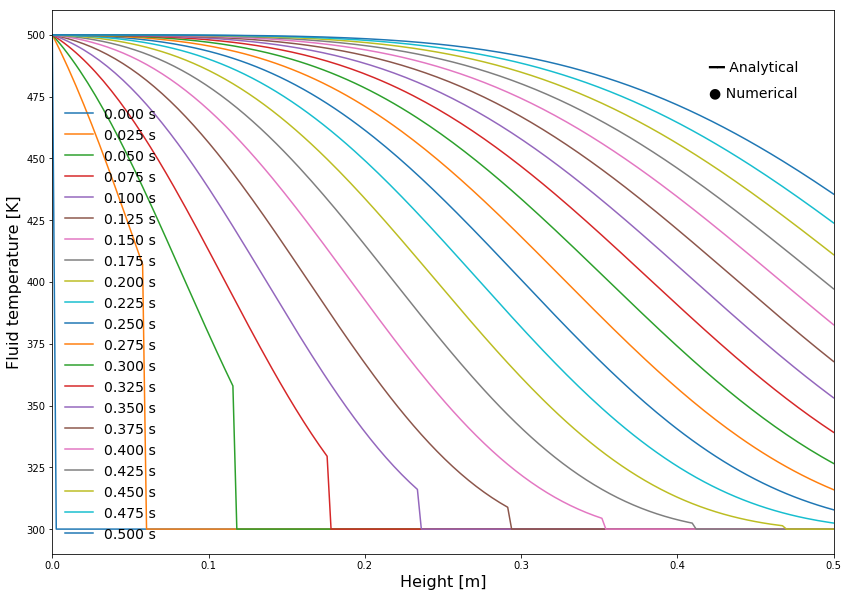

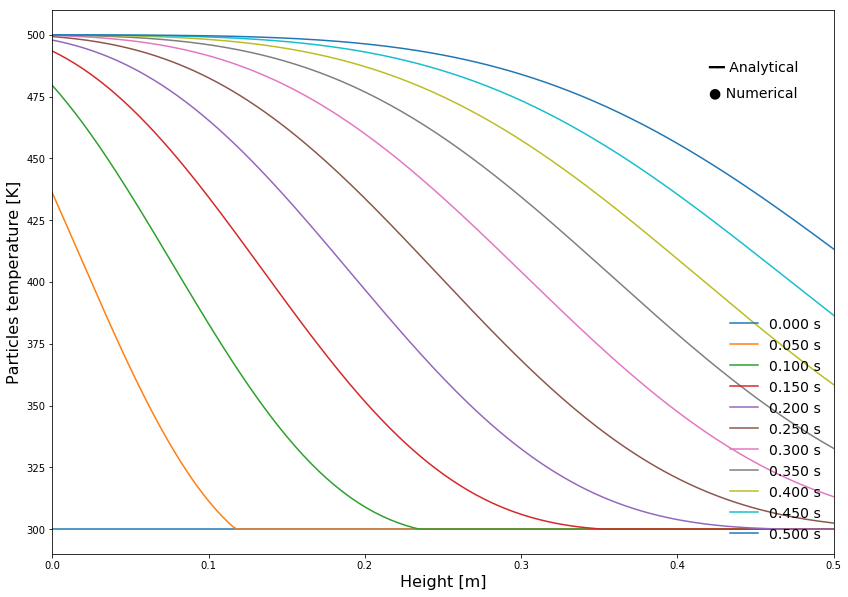

In [149]:
# Fluid temperature x height for each time

i = 5
inc = 5

cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)

#for time in num_time[i:50:inc]:
for time in numpy.linspace(0,0.5,21):
    
    zStar = (y * h_g / U)

    tStart = time*h_p - (y/U)*h_p

    TgStart = packedBedTrnsTemperatures(tStart,zStar )[0]

    Tg = TgStart*(T_gi-T_g0) + T_g0

    for index in numpy.where(tStart < 0.0):
        Tg[index] = T_g0
  
    plt.plot(y, Tg, label = "{0:.3f} s".format(time))
    #plt.plot(num_y, temperature[i], marker = 'o', markersize = 7.5, linestyle = 'None', color = cmap(i*5))
    i = i + inc
    

#plt.ylim(300, 500)     
plt.xlim(0, 0.5) 

plt.legend(fontsize=14, loc='lower left', frameon=False)
plt.ylabel('Fluid temperature [K]', fontsize=16)
plt.xlabel('Height [m]', fontsize=16)
plt.annotate('━━ Analytical',xy=(0.420, 485), fontsize=14)
plt.annotate('● Numerical', xy=(0.420, 475), fontsize=14)
plt.savefig('gasversusposition.png')
plt.show()

# Fluid temperature x height for each time

i = 5
inc = 5

cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)

#for time in num_time[i:50:inc]:
for time in numpy.linspace(0,0.5,11):
    
    zStar = (y * h_g / U)

    tStart = time*h_p - (y/U)*h_p

    TpStart = packedBedTrnsTemperatures(tStart,zStar )[1]

    Tp = TpStart*(T_gi-T_g0) + T_g0

    for index in numpy.where(tStart < 0.0):
        Tp[index] = T_p0
  
    plt.plot(y, Tp, label = "{0:.3f} s".format(time))
    #plt.plot(num_y, temperature[i], marker = 'o', markersize = 7.5, linestyle = 'None', color = cmap(i*5))
    i = i + inc
    

#plt.ylim(300, 500)     
plt.xlim(0, 0.5) 

plt.legend(fontsize=14, loc='lower right', frameon=False)
plt.ylabel('Particles temperature [K]', fontsize=16)
plt.xlabel('Height [m]', fontsize=16)
plt.annotate('━━ Analytical',xy=(0.420, 485), fontsize=14)
plt.annotate('● Numerical', xy=(0.420, 475), fontsize=14)
plt.savefig('particlesversusposition.png')
plt.show()

